In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def plot_series(time, series, format = "-", 
                start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)
  
  
def trend(time, slope = 0):
  return slope * time

In [13]:
def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude = 1, phase = 0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [14]:
time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [15]:
## Create the series
series = baseline + trend(time, slope) + \
         seasonality(time, period = 365,
                     amplitude = amplitude)

## Update with noise
series += noise(time, noise_level, seed = 42)

In [16]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1,
                           drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size,
                           shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(dataset, epochs = 100,
                    callbacks = [lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
31/31 [==============================] - 6s 25ms/step - loss: 21.5167 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 1s 25ms/step - loss: 21.1522 - mae: 21.6444
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 20.7302 - mae: 21.2236
Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 20.2834 - mae: 20.7757
Epoch 5/100
31/31 [==============================] - 1s 24ms/step - loss: 19.7897 - mae: 20.2855
Epoch 6/100
31/31 [==============================] - 1s 25ms/step - loss: 19.1782 - mae: 19.6696
Epoch 7/100
31/31 [==============================] - 1s 25ms/step - loss: 18.2410 - mae: 18.7333
Epoch 8/100
31/31 [==============================] - 1s 25ms/step - loss: 17.4825 - mae: 17.9748
Epoch 9/100
31/31 [==============================] - 1s 25ms/step - loss: 17.1597 - mae: 17.6529
Epoch 10/100
31/31 [==============================] - 1s 24ms/step - loss: 16.8547 - mae: 17.3463
Epoch 11/100
31/31 [=========

(1e-08, 0.0001, 0.0, 30.0)

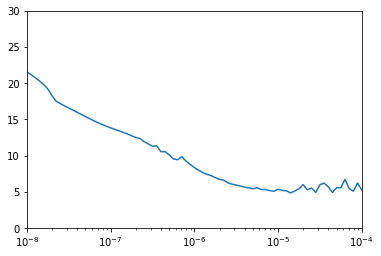

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 30])

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size,
                           shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),
              metrics = ["mae"])

history = model.fit(dataset, epochs = 500, verbose = 0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


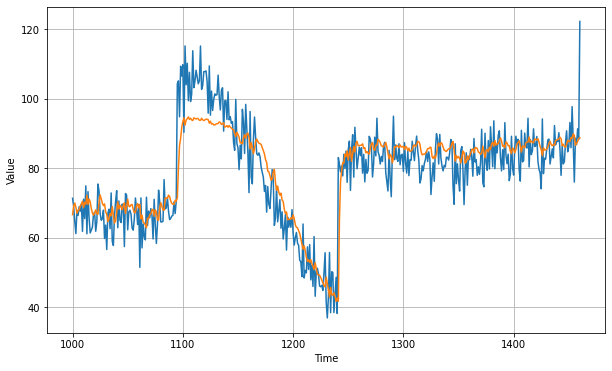

In [21]:
forecast = []
results = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  
forecast = forecast[split_time - window_size : ]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.637738

<Figure size 432x288 with 0 Axes>

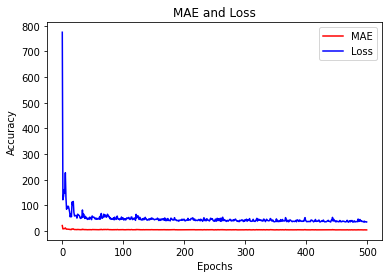

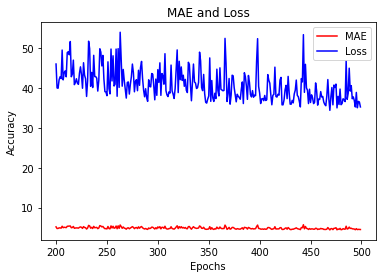

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#---------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#---------------------------------------------------------

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#---------------------------------------------------------
# Plot MAE and Loss
#---------------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200 : ]
mae_zoom = mae[200 : ]
loss_zoom = loss[200 : ]

#---------------------------------------------------------
# Plot Zoomed MAE and Loss
#---------------------------------------------------------

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [24]:
tf.keras.backend.clear_session()

dataset = windowed_dataset(x_train, window_size, batch_size,
                           shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))

model.fit(dataset, epochs = 500, verbose = 0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


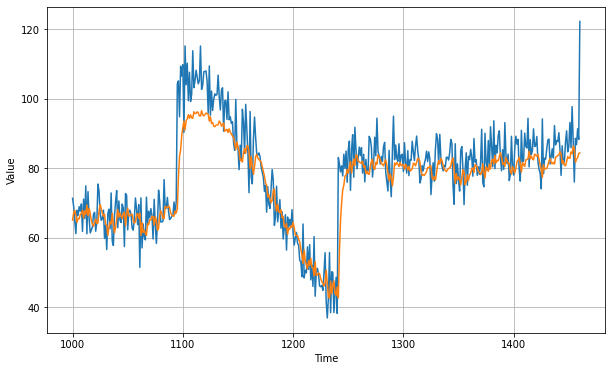

In [25]:
forecast = []
results = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  
forecast = forecast[split_time - window_size : ]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

<Figure size 432x288 with 0 Axes>

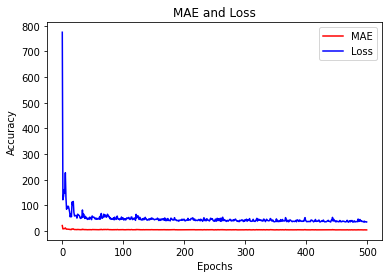

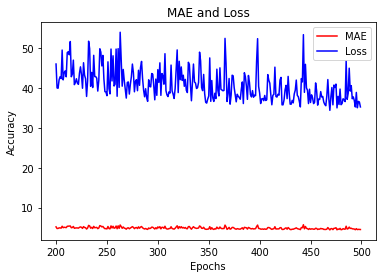

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#---------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#---------------------------------------------------------

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#---------------------------------------------------------
# Plot MAE and Loss
#---------------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200 : ]
mae_zoom = mae[200 : ]
loss_zoom = loss[200 : ]

#---------------------------------------------------------
# Plot Zoomed MAE and Loss
#---------------------------------------------------------

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.5034003

In [28]:
tf.keras.backend.clear_session()

dataset = windowed_dataset(x_train, window_size, batch_size,
                           shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))

model.fit(dataset, epochs = 500, verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
31/31 [==============================] - 10s 39ms/step - loss: 755.7012
Epoch 2/500
31/31 [==============================] - 1s 39ms/step - loss: 152.7785
Epoch 3/500
31/31 [==============================] - 1s 39ms/step - loss: 97.9761
Epoch 4/500
31/31 [==============================] - 1s 38ms/step - loss: 83.2915
Epoch 5/500
31/31 [==============================] - 1s 38ms/step - loss: 78.2600
Epoch 6/500
31/31 [==============================] - 1s 38ms/step - loss: 73.4347
Epoch 7/500
31/31 [==============================] - 1s 39ms/step - loss: 67.8632
Epoch 8/500
31/31 [==============================] - 1s 38ms/step - loss: 74.5354
Epoch 9/500
31/31 [==============================] - 1s 38ms/step - loss: 73.1458
Epoch 10/500
31/31 [==============================] - 1s 38ms/step - loss: 63.4809
Epoch 11/500
31/31 [==============================] - 1s 38ms/step - loss: 60.9757
Epoch 12/500
31/31 [==============================] - 1s 38ms/step - loss: 57.7044
Epoch 13/5

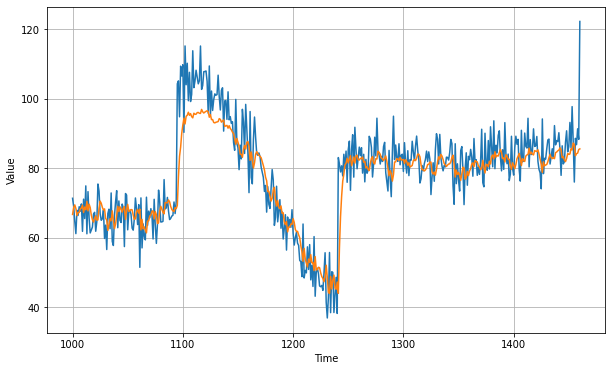

In [29]:
forecast = []
results = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  
forecast = forecast[split_time - window_size : ]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

<Figure size 432x288 with 0 Axes>

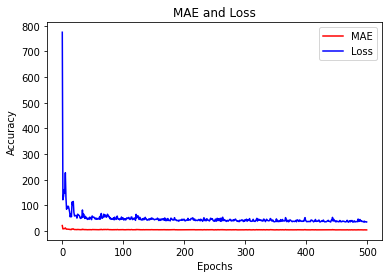

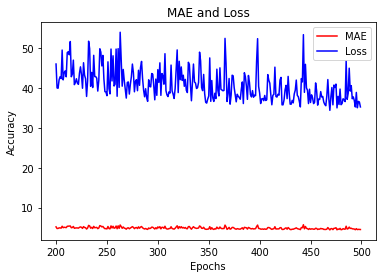

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#---------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#---------------------------------------------------------

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#---------------------------------------------------------
# Plot MAE and Loss
#---------------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200 : ]
mae_zoom = mae[200 : ]
loss_zoom = loss[200 : ]

#---------------------------------------------------------
# Plot Zoomed MAE and Loss
#---------------------------------------------------------

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [31]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2784033